# Addressing Imbalance in APS Failure Prediction Using Advanced Ensemble Techniques

Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold

## 1. Exploration of Tree-Based Methods:

### (a) Dataset Acquisition and Characteristics:

For this investigation, the APS Failure dataset was sourced from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks). The dataset comprises a training set with 60,000 rows, 1,000 of which belong to the positive class, and includes 171 numeric columns, with one designated as the class column.

In [2]:
training_file_path = '../aps_failure_training_set.csv'
test_file_path = '../aps_failure_test_set.csv'
training_data = pd.read_csv(training_file_path, skiprows=20, na_values='na')
test_data = pd.read_csv(test_file_path, skiprows=20, na_values='na')
print("Training Dataset:")
print(training_data.head())
print("\nTest Dataset:")
print(test_data.head())

Training Dataset:
  class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0   neg   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0     0.0   
1   neg   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0     0.0   
2   neg   41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0     0.0   
3   neg      12     0.0  7.000000e+01    66.0     0.0    10.0     0.0     0.0   
4   neg   60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0     0.0   

   ag_002  ...     ee_002    ee_003    ee_004    ee_005    ee_006    ee_007  \
0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0  157956.0   
1     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   81140.0   
2     0.0  ...   277378.0  159812.0  423992.0  409564.0  320746.0  158022.0   
3     0.0  ...      240.0      46.0      58.0      44.0      10.0       0.0   
4     0.0  ...   622012.0  229790.0  405298.0  347188.0  286954.0  311560.0   

     ee_008  ee_009 

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

1. Replace missing values with the mean or median of the available values for that feature. 
2. Replace missing categorical values with the mode.
3. Predict missing values using a regression model trained on the other features.
4. Replace missing values with the average of the nearest neighbors' values in the feature space.
5. Remove rows or columns with missing values. 

#### (ii) Feature Analysis:

For each of the 170 features, the coefficient of variation (CV) will be calculated using the formula CV = s/m, where s is the sample standard deviation and m is the sample mean.

In [3]:
data = pd.concat([training_data, test_data], ignore_index=True)
cv_data = []
for column in data.columns:
    if column != 'class': 
        mean = data[column].mean()
        std = data[column].std()
        cv = std / mean 
        cv_data.append({'Feature': column, 'CV': cv})
cv_df = pd.DataFrame(cv_data)
print(cv_df)

    Feature          CV
0    aa_000    4.328608
1    ab_000    4.564627
2    ac_000    2.231100
3    ad_000  238.371798
4    ae_000   22.776814
..      ...         ...
165  ee_007    4.913072
166  ee_008    3.354135
167  ee_009    5.786883
168  ef_000   49.057869
169  eg_000   46.735063

[170 rows x 2 columns]


#### (iii) Correlation Matrix:

A correlation matrix will be generated for the features, utilizing tools such as pandas, to unveil potential relationships within the dataset.

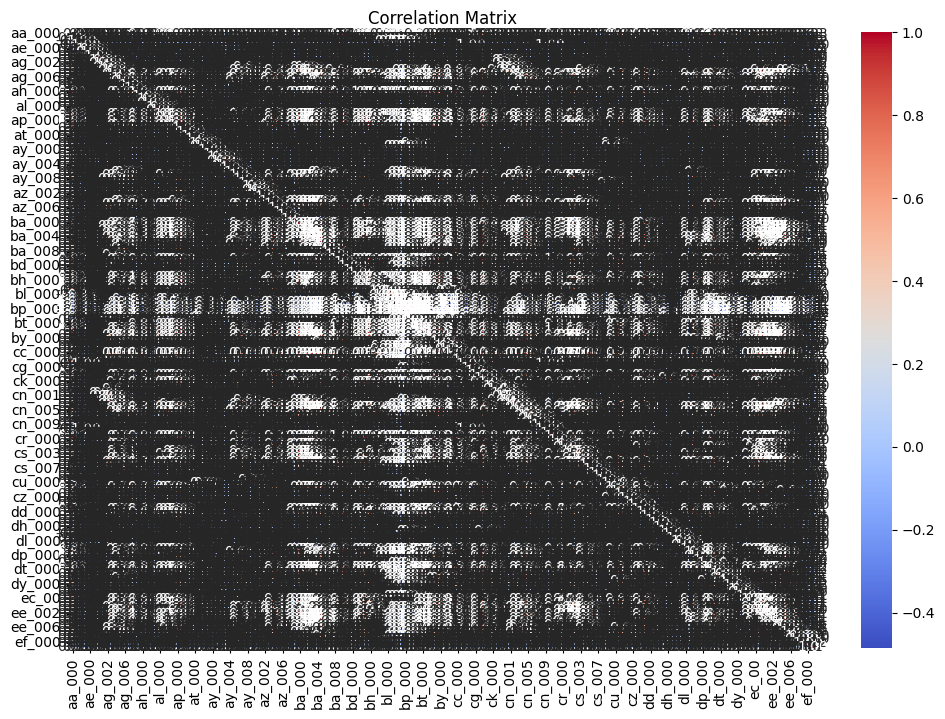

In [4]:
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### (iv) Feature Selection:

Selecting √170 features with the highest CV, scatter plots and box plots similar to those on page 129 of ISLR will be created for visualization purposes. Initial conclusions regarding the significance of these features will be drawn from the visualizations.

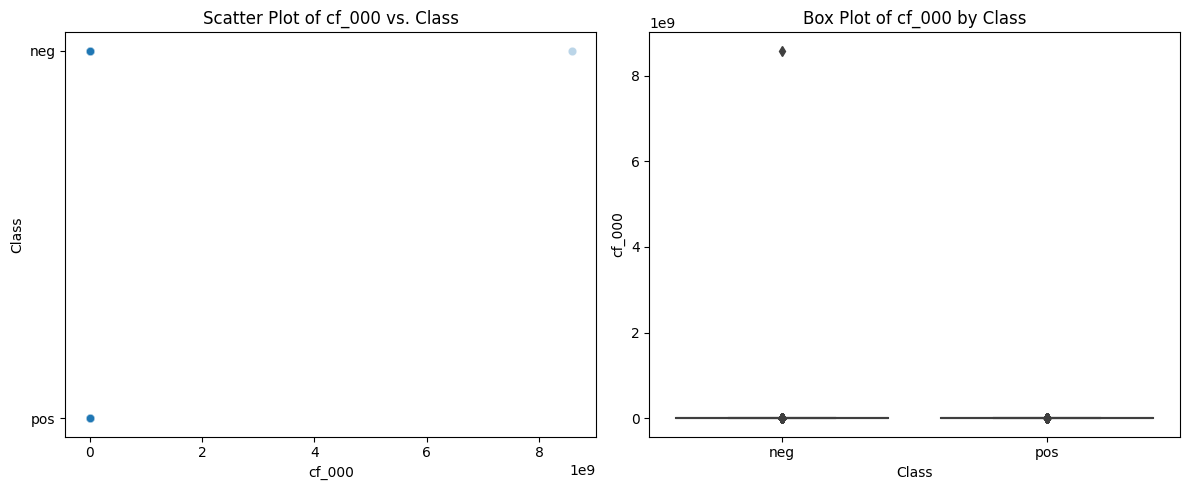

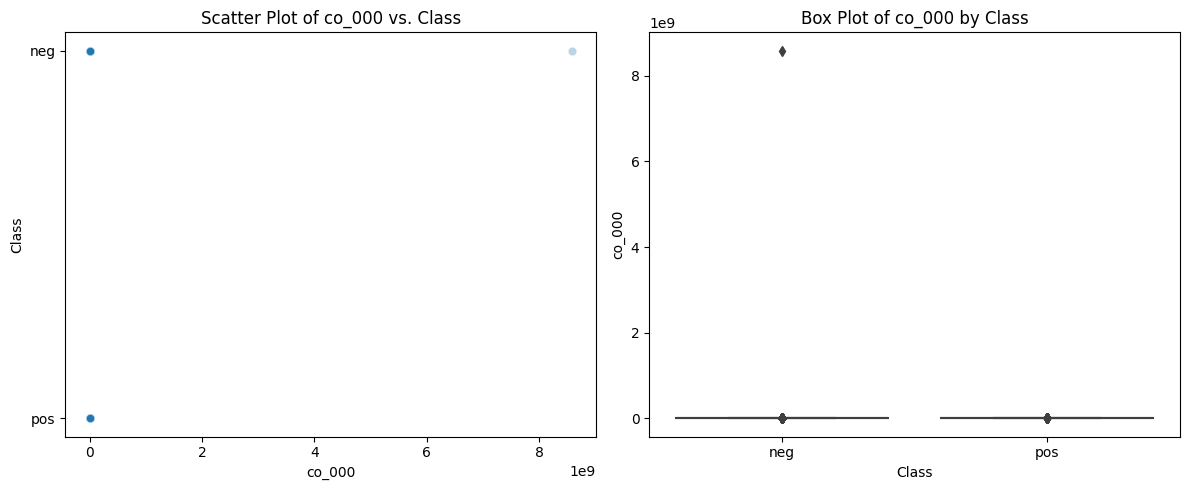

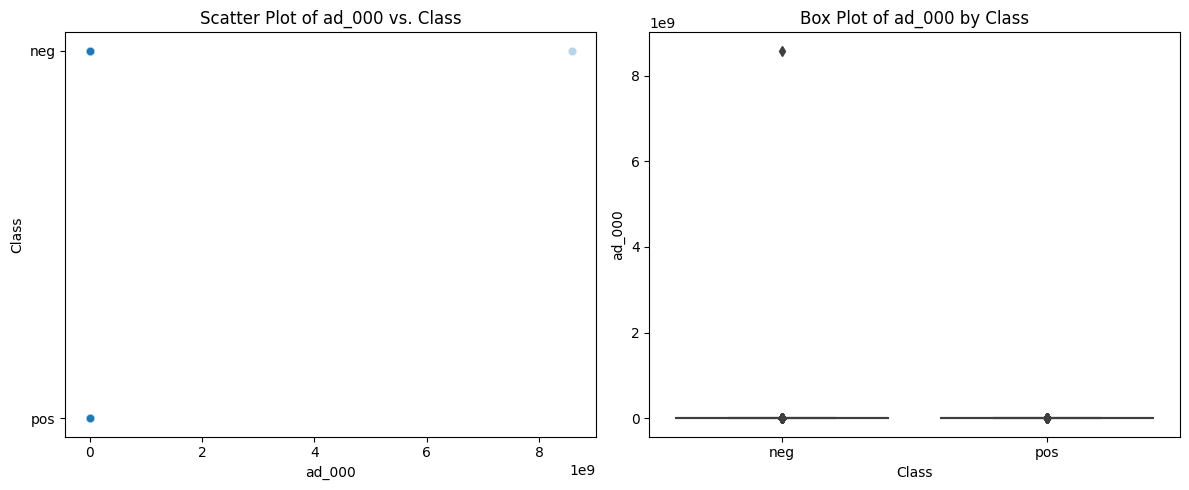

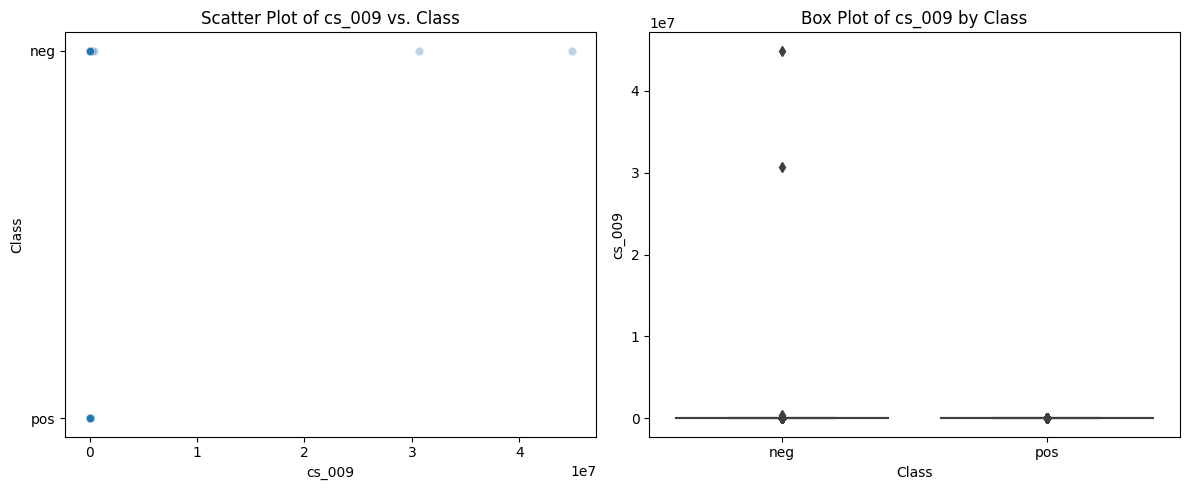

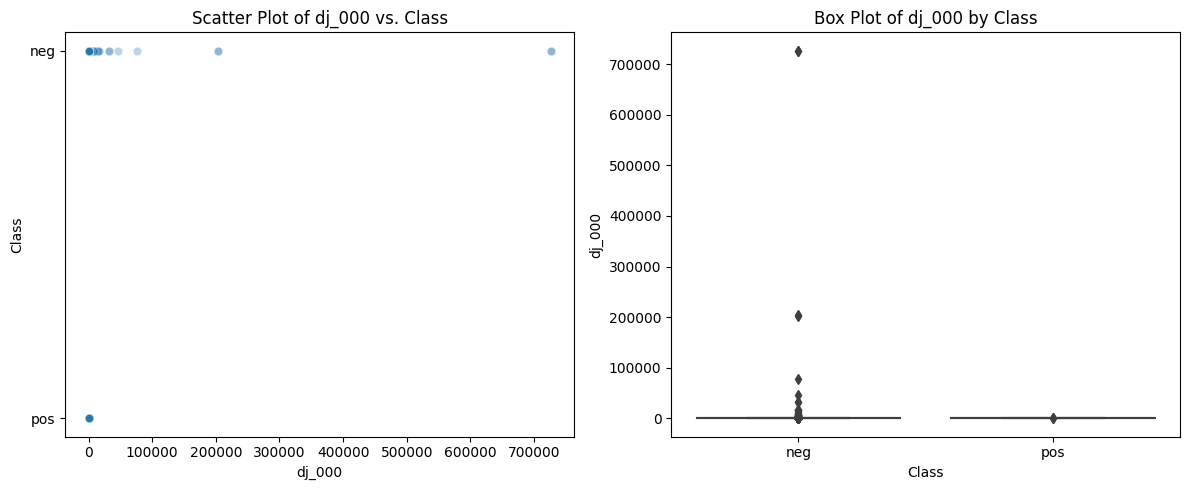

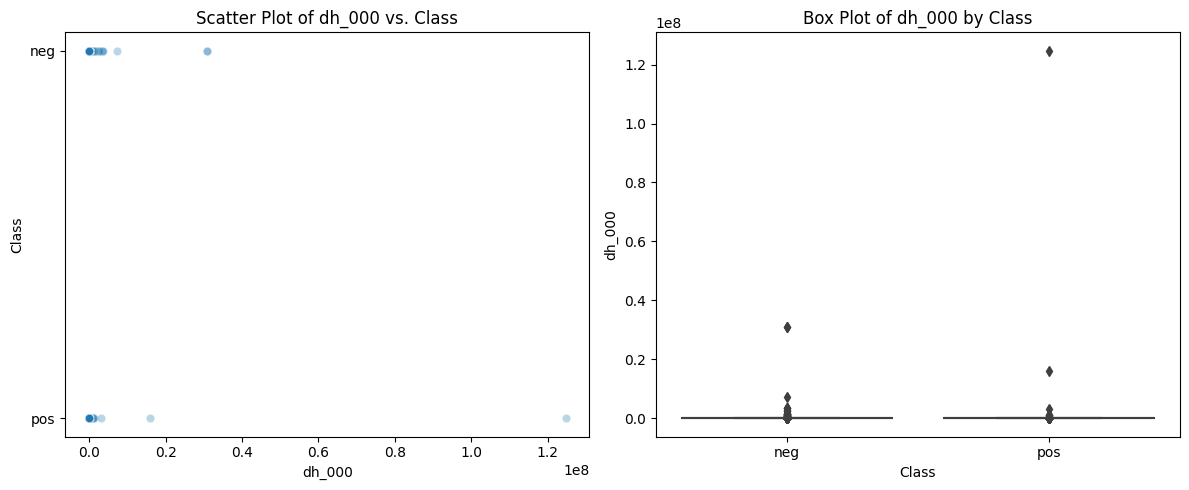

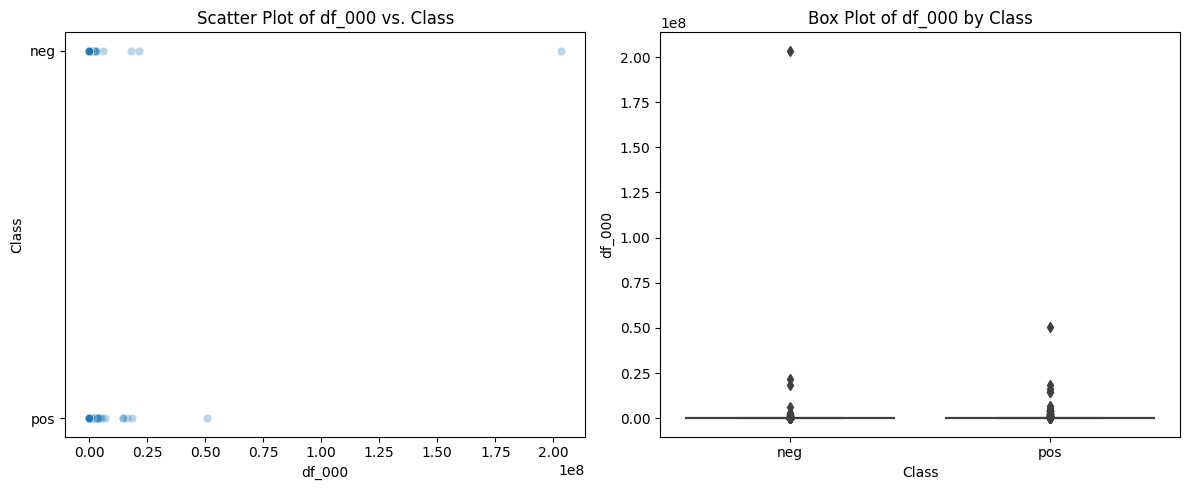

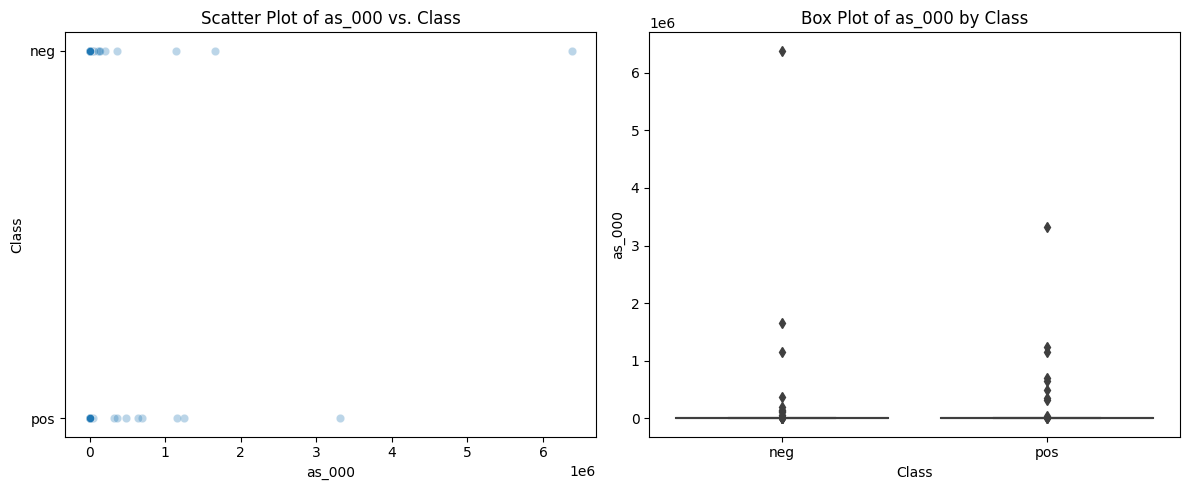

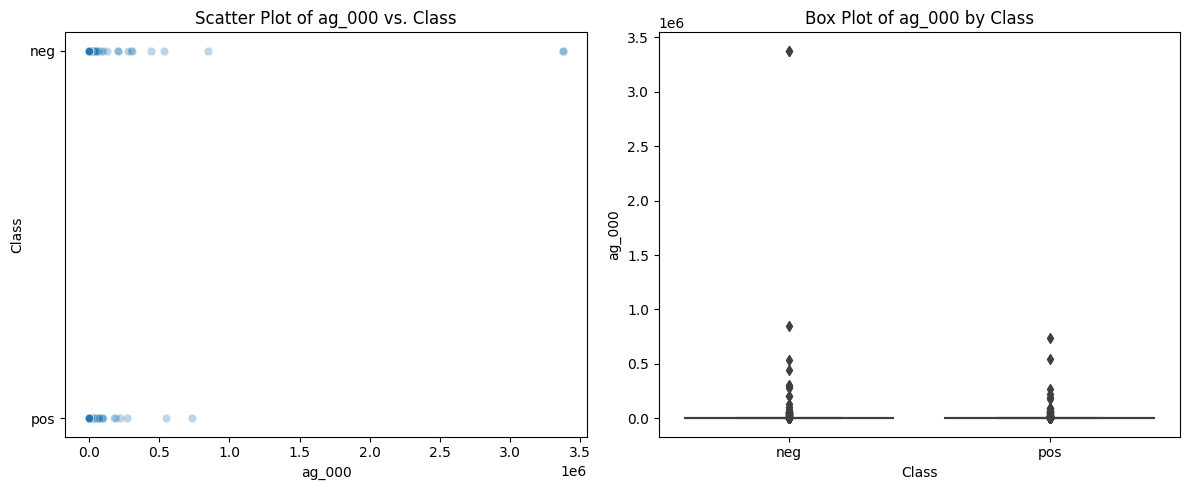

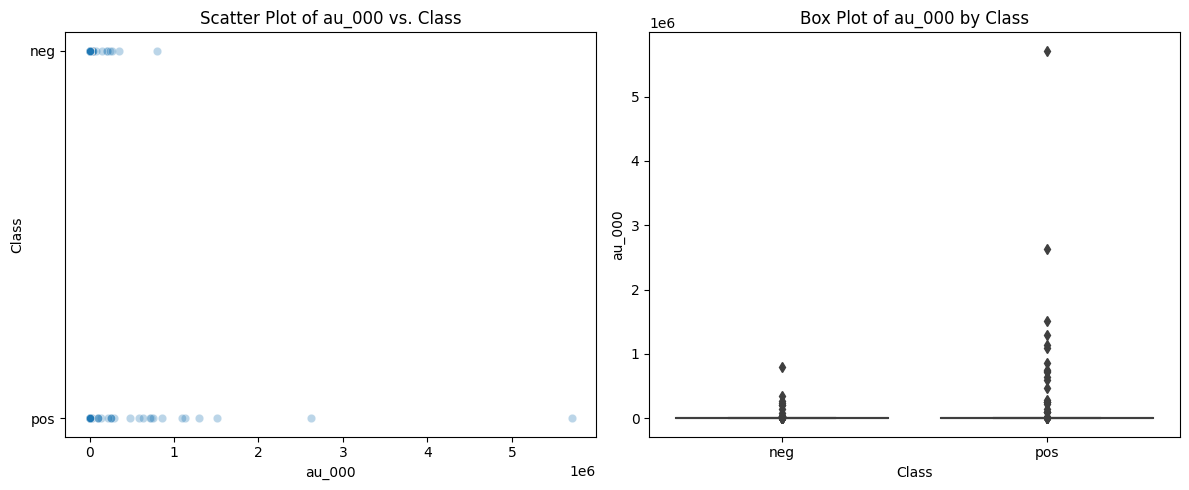

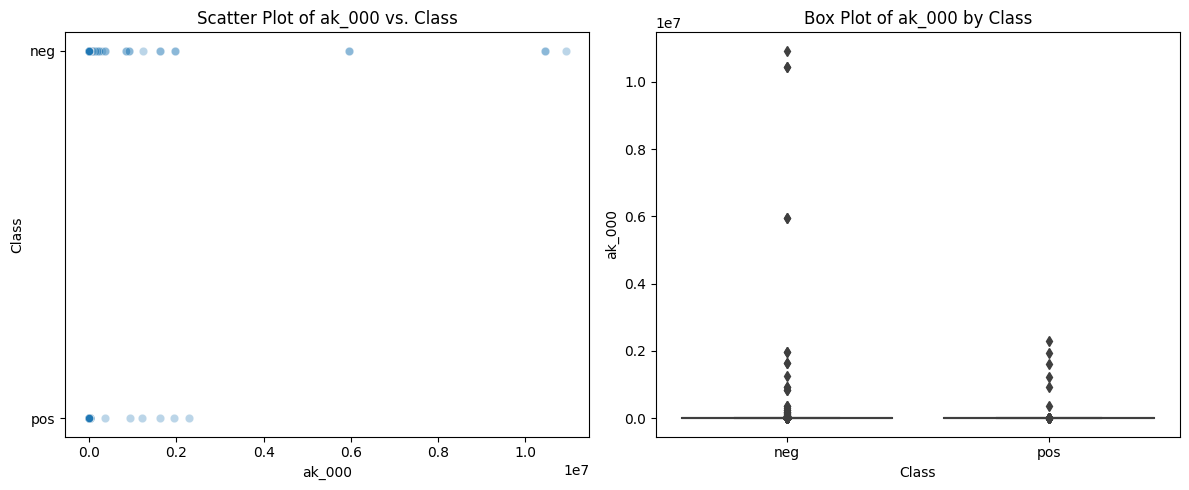

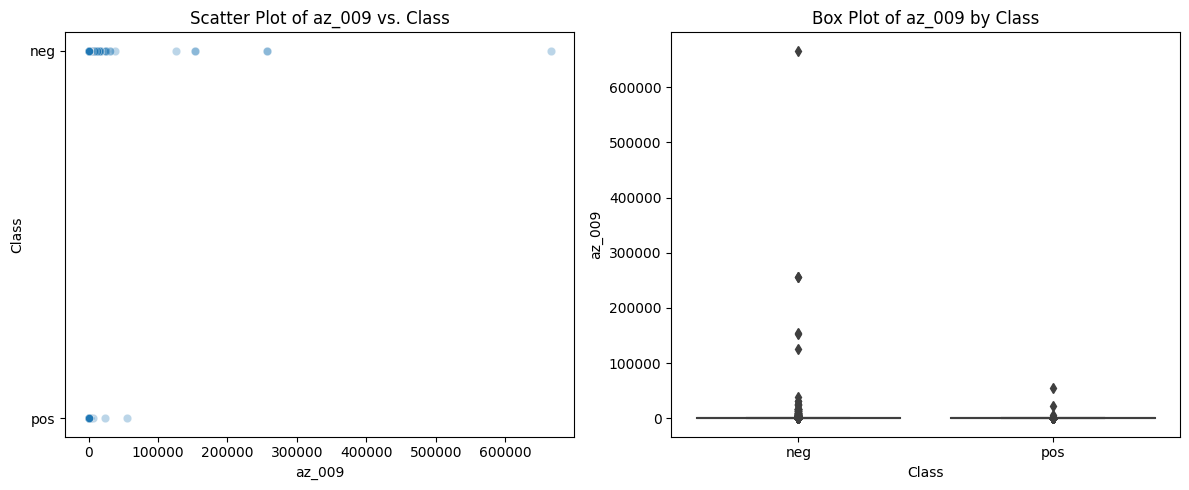

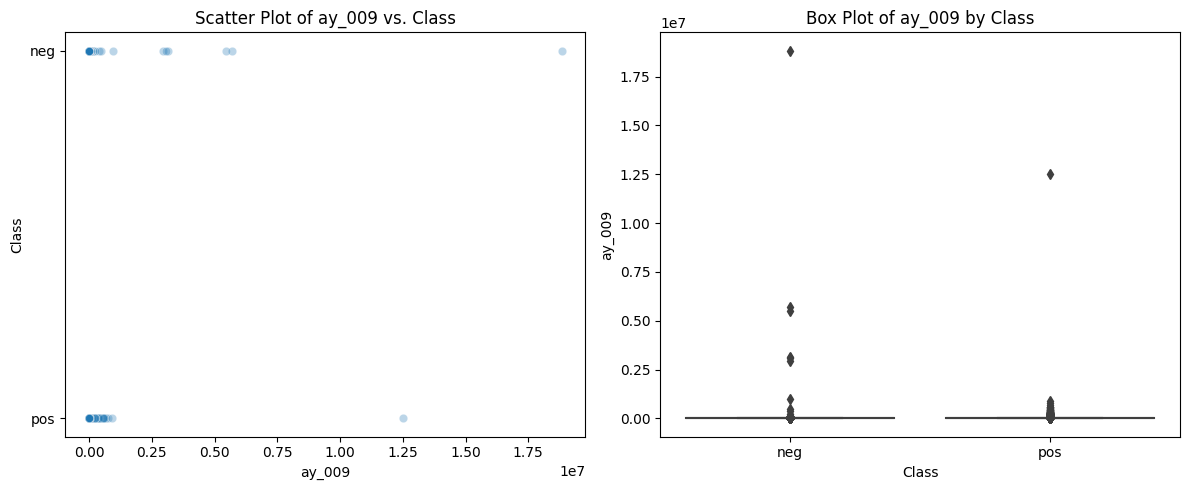

In [5]:
cv_df_sorted = cv_df.sort_values(by='CV', ascending=False)
num_features = int(np.sqrt(170))
top_features = cv_df_sorted.head(num_features)
for feature in top_features['Feature']:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=data[feature], y=data['class'], alpha=0.3)
    plt.xlabel(feature)
    plt.ylabel('Class')
    plt.title(f'Scatter Plot of {feature} vs. Class')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data['class'], y=data[feature])
    plt.xlabel('Class')
    plt.ylabel(feature)
    plt.title(f'Box Plot of {feature} by Class')
    plt.tight_layout()
    plt.show()

#### (v) Imbalance Assessment:

The number of positive and negative instances will be determined to evaluate the imbalance in the dataset.

In [4]:
positive_count = (data['class'] == 'pos').sum()
negative_count = (data['class'] == 'neg').sum()

print("Number of Positive Samples:", positive_count)
print("Number of Negative Samples:", negative_count)
if positive_count > negative_count:
    imbalance_ratio = negative_count / positive_count
    print("The dataset is imbalanced with a negative-to-positive ratio of", imbalance_ratio)
elif negative_count > positive_count:
    imbalance_ratio = positive_count / negative_count
    print("The dataset is imbalanced with a positive-to-negative ratio of", imbalance_ratio)
else:
    print("The dataset is balanced.")

Number of Positive Samples: 1375
Number of Negative Samples: 74625
The dataset is imbalanced with a positive-to-negative ratio of 0.018425460636515914


### (c) Random Forest Classification:

#### (i) Training the Model

Train a random forest classifier on the dataset without compensating for class imbalance. Evaluate model performance using metrics such as the confusion matrix, ROC, AUC, and misclassification for both training and test sets. Additionally, compute the Out of Bag error estimate and compare it with the test error.

Confusion Matrix (Training Set):
 [[515   0]
 [  0  76]]

Confusion Matrix (Test Set):
 [[133   2]
 [  3  27]]

ROC AUC: 0.9425925925925925

Misclassification Rate (Training Set): 0.0

Misclassification Rate (Test Set): 0.030303030303030276


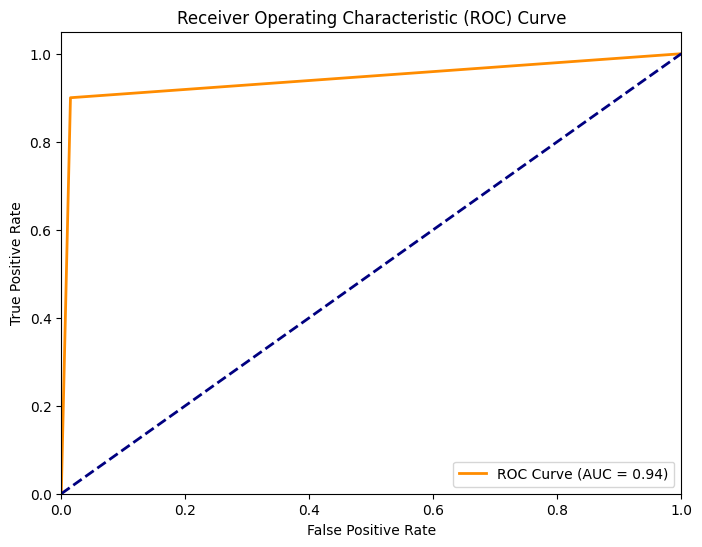

In [4]:
training_data_cleaned = training_data.dropna()
test_data_cleaned = test_data.dropna()

X_train = training_data_cleaned.drop(columns=['class'])
y_train = training_data_cleaned['class']
X_test = test_data_cleaned.drop(columns=['class'])
y_test = test_data_cleaned['class']
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train_encoded)
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

confusion_matrix_train = confusion_matrix(y_train_encoded, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test_encoded, y_test_pred)

fpr, tpr, _ = roc_curve(y_test_encoded, y_test_pred)
roc_auc = auc(fpr, tpr)
misclassification_train = 1 - accuracy_score(y_train_encoded, y_train_pred)
misclassification_test = 1 - accuracy_score(y_test_encoded, y_test_pred)
print("Confusion Matrix (Training Set):\n", confusion_matrix_train)
print("\nConfusion Matrix (Test Set):\n", confusion_matrix_test)
print("\nROC AUC:", roc_auc)
print("\nMisclassification Rate (Training Set):", misclassification_train)
print("\nMisclassification Rate (Test Set):", misclassification_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### (d) Addressing Class Imbalance in Random Forests:

Research on strategies to mitigate class imbalance in random forests will be conducted. Subsequently, class imbalance compensation will be implemented, and the model performance will be compared with the initial random forest model.

Confusion Matrix (Training Set):
 [[515   0]
 [  0  76]]

Confusion Matrix (Test Set):
 [[133   2]
 [  8  22]]

ROC AUC: 0.8592592592592592

Misclassification Rate (Training Set): 0.0

Misclassification Rate (Test Set): 0.06060606060606055


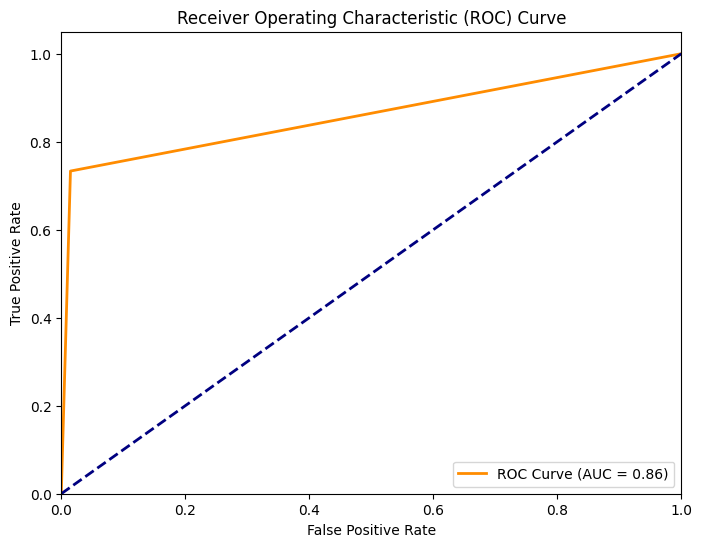

In [6]:
class_weights = {0: 1.0, 1: 10.0} 
rf_classifier_balanced = RandomForestClassifier(class_weight=class_weights, random_state=42)
rf_classifier_balanced.fit(X_train, y_train_encoded)

y_train_pred = rf_classifier_balanced.predict(X_train)
y_test_pred = rf_classifier_balanced.predict(X_test)

confusion_matrix_train = confusion_matrix(y_train_encoded, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test_encoded, y_test_pred)

fpr, tpr, _ = roc_curve(y_test_encoded, y_test_pred)
roc_auc = auc(fpr, tpr)
misclassification_train = 1 - accuracy_score(y_train_encoded, y_train_pred)
misclassification_test = 1 - accuracy_score(y_test_encoded, y_test_pred)
print("Confusion Matrix (Training Set):\n", confusion_matrix_train)
print("\nConfusion Matrix (Test Set):\n", confusion_matrix_test)
print("\nROC AUC:", roc_auc)
print("\nMisclassification Rate (Training Set):", misclassification_train)
print("\nMisclassification Rate (Test Set):", misclassification_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### (e) XGBoost and Model Trees

Explore the distinctions between univariate and multivariate trees, emphasizing model trees' utilization of linear models incorporating all variables. Integrate Logistic Regression at each node, utilizing L1-penalized logistic regression due to the dataset's large number of variables. Determine the regularization term (α) through cross-validation and train the model on the APS dataset without compensating for class imbalance. Employ 5-fold, 10-fold, and leave-one-out cross-validation methods to estimate model error, comparing it with the test error. Report key performance metrics such as the Confusion Matrix, ROC, and AUC for both training and test sets.

In [18]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
alpha_values = [0.01, 0.1, 1.0, 10.0]

best_alpha = None
best_auc = 0.0

for alpha in alpha_values:
    auc_scores = []  
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

        params = {
            'objective': 'binary:logistic',
            'alpha': alpha,  
        }

        bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], early_stopping_rounds=10, verbose_eval=False)

        y_val_pred = bst.predict(dval)

        fpr_val, tpr_val, _ = roc_curve(y_val_fold, y_val_pred)
        roc_auc_val = auc(fpr_val, tpr_val)
        auc_scores.append(roc_auc_val)

    avg_auc = np.mean(auc_scores)

    if avg_auc > best_auc:
        best_alpha = alpha
        best_auc = avg_auc

print("Best Alpha:", best_alpha)
print("Best AUC:", best_auc)

dtrain_final = xgb.DMatrix(X_train, label=y_train_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

params_final = {
    'objective': 'binary:logistic',
    'alpha': best_alpha,  
}

bst_final = xgb.train(params_final, dtrain_final, num_boost_round=100, evals=[(dtest, 'eval')], early_stopping_rounds=10, verbose_eval=False)

y_train_pred = bst_final.predict(dtrain_final)
y_test_pred = bst_final.predict(dtest)

fpr_train, tpr_train, _ = roc_curve(y_train_encoded, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test_encoded, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

print("Training ROC AUC:", roc_auc_train)
print("Test ROC AUC:", roc_auc_test)

y_test_pred_binary = (y_test_pred > 0.5).astype(int)
confusion = confusion_matrix(y_test_encoded, y_test_pred_binary)
print("Confusion Matrix (Test Set):")
print(confusion)

Best Alpha: 1.0
Best AUC: 0.978754996624237
Training ROC AUC: 1.0
Test ROC AUC: 0.9859259259259259
Confusion Matrix (Test Set):
[[135   0]
 [  4  26]]


### (f) Class Imbalance Compensation using SMOTE:

Utilize Synthetic Minority Over-sampling Technique (SMOTE) as a pre-processing step to address class imbalance. Train XGBoost with L1-penalized logistic regression at each node using the pre-processed data. Repeat the analysis from section 1e, emphasizing correct cross-validation methods. Perform a comparative assessment between the uncompensated and SMOTE-compensated cases.

In [26]:
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)
y_train_resampled_df = pd.Series(y_train_resampled, name='class')

alpha_values = [0.01, 0.1, 1.0, 10.0]

best_alpha = None
best_auc = 0.0

for alpha in alpha_values:
    auc_scores = [] 
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X_train_resampled_df):
        X_train_fold, X_val_fold = X_train_resampled_df.iloc[train_index], X_train_resampled_df.iloc[val_index]
        y_train_fold, y_val_fold = y_train_resampled_df.iloc[train_index], y_train_resampled_df.iloc[val_index]

        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

        params = {
            'objective': 'binary:logistic',
            'alpha': alpha,  
        }
        
        bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], early_stopping_rounds=10, verbose_eval=False)

        y_val_pred = bst.predict(dval)

        fpr_val, tpr_val, _ = roc_curve(y_val_fold, y_val_pred)
        roc_auc_val = auc(fpr_val, tpr_val)
        auc_scores.append(roc_auc_val)
    avg_auc = np.mean(auc_scores)

    if avg_auc > best_auc:
        best_alpha = alpha
        best_auc = avg_auc

print("Best Alpha:", best_alpha)
print("Best AUC:", best_auc)

dtrain_final = xgb.DMatrix(X_train_resampled_df, label=y_train_resampled_df)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

params_final = {
    'objective': 'binary:logistic',
    'alpha': best_alpha, 
}

bst_final = xgb.train(params_final, dtrain_final, num_boost_round=100, evals=[(dtest, 'eval')], early_stopping_rounds=10, verbose_eval=False)
y_train_pred = bst_final.predict(dtrain_final)

y_test_pred = bst_final.predict(dtest)

fpr_train, tpr_train, _ = roc_curve(y_train_resampled_df, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test_encoded, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

print("Training ROC AUC:", roc_auc_train)
print("Test ROC AUC:", roc_auc_test)

y_test_pred_binary = (y_test_pred > 0.5).astype(int)
confusion = confusion_matrix(y_test_encoded, y_test_pred_binary)
print("Confusion Matrix (Test Set):")
print(confusion)

Best Alpha: 0.01
Best AUC: 0.9990603725703024
Training ROC AUC: 1.0
Test ROC AUC: 0.985925925925926
Confusion Matrix (Test Set):
[[132   3]
 [  3  27]]
